# MACHINE LEARNING OLS

In [71]:
#Importing libaries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy import stats
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge


In [73]:
#Importing data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)
csv_file_path = '../Modeldata/data_ready_udenkom.csv'
df_final = pd.read_csv(csv_file_path)
df_final
df_final.set_index('Unnamed: 0', inplace=True)
df_final.index.name = None
print(len(df_final))

19848


In [75]:
##Deleting observations with less than 20 m2 -> To avoid "non-appartments"
outliers_m2 = df_final[(df_final['m2'] < 20) | ((df_final['m2'] < 50) & (df_final['Boligtype_Landejendom'] == 1))]
#print(outliers_m2)
df_final = df_final.drop(outliers_m2.index)

#Square meter price:
df_final['price/m2'] = df_final['Price']/df_final['m2']

print(len(df_final))
########################################################################
# Calculate Z-scores for each value in the column
df_final['z_score_price_m2'] = stats.zscore(df_final['price/m2'])

# Define outliers as any points with a Z-score > 4 or < -4
outliers = df_final[(df_final['z_score_price_m2'] > 3) | (df_final['z_score_price_m2'] < -3)]
#print(outliers.sort_values(by='price/m2', ascending=False))

df_final = df_final.drop(outliers.index)
df_final.drop(columns='price/m2', inplace=True)
########################################################################
# Calculate Z-scores for m2
df_final['z_score_m2'] = stats.zscore(df_final['m2'])

# Define outliers as any points with a Z-score > 4 or < -4
outliers_m2 = df_final[(df_final['z_score_m2'] > 3) | (df_final['z_score_m2'] < -3)]
#print(outliers_m2.sort_values(by='m2', ascending=True))
print(len(outliers_m2))
df_final = df_final.drop(outliers_m2.index)
print(len(df_final))

########################################################################

#Calculate Z-scores for price
df_final['z_score_price'] = stats.zscore(df_final['Price'])
# Define outliers as any points with a Z-score > 4 or < -4
outliers_price = df_final[(df_final['z_score_price'] > 3) | (df_final['z_score_price'] < -3)]
#print(outliers_m2.sort_values(by='m2', ascending=True))
df_final = df_final.drop(outliers_price.index)


print(len(df_final))

df_final = df_final.drop('z_score_m2', axis=1)
df_final = df_final.drop('z_score_price_m2', axis=1)
df_final = df_final.drop('z_score_price', axis=1)


#print(df_final.sort_values(by='price/m2', ascending=True))

19845
253
19278
18861


In [77]:
y = df_final['Price']
X = df_final.drop(columns=['Price'])

In [79]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=42) #The random_state works as a seed

#2
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

# OLS, Poly-degree=1

In [7]:
# DEFINE PIPELINE
pipe_lr = make_pipeline(PolynomialFeatures(degree=1), 
                        StandardScaler(),
                        LinearRegression())

# FIT PIPELINE TO DEVELOPMENT DATA
pipe_lr.fit(X_dev, y_dev)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

LinReg_MSE 1488586360216.93
LinReg_MAE 882083.85
LinReg_MAPE 0.81
LinReg_RMSE 1220076.3747474689
LinReg_r2 0.6100684098778397


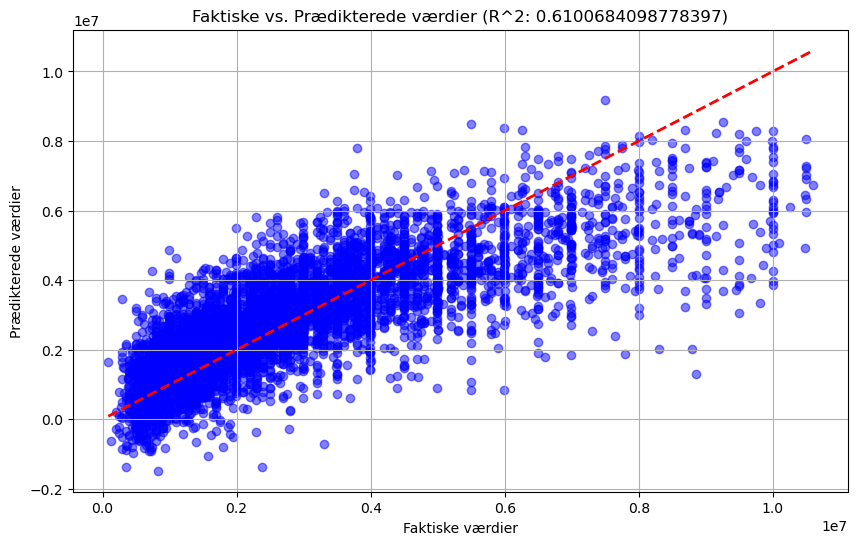

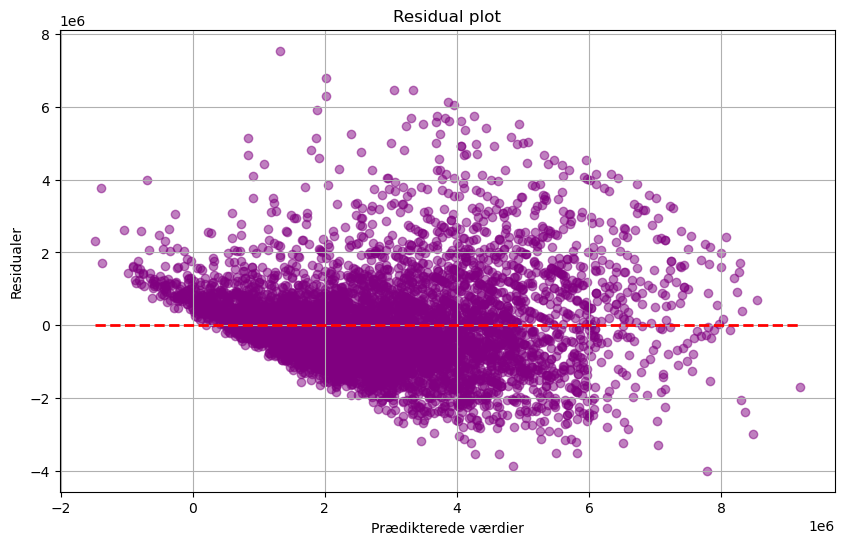

In [8]:
y_predict_lr_degree_1 = pipe_lr.predict(X_test)
print('LinReg_MSE', round(mse(y_predict_lr_degree_1,y_test), 2))
print('LinReg_MAE', round(mean_absolute_error(y_predict_lr_degree_1, y_test), 2))
print('LinReg_MAPE', round(mean_absolute_percentage_error(y_predict_lr_degree_1, y_test), 2))
print('LinReg_RMSE', np.sqrt(mse(y_predict_lr_degree_1, y_test)))
print('LinReg_r2', r2_score(y_test, y_predict_lr_degree_1))
linear_model = pipe_lr.named_steps['linearregression']
coeff = linear_model.coef_

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict_lr_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_predict_lr_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_predict_lr_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_predict_lr_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_predict_lr_degree_1.min(), y_predict_lr_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# OLS, Poly-degree = 2

In [10]:
# Initializing Linear-regression-model with degree=2
from sklearn.linear_model import Lasso, LinearRegression

# DEFINE PIPELINE
pipe_lr = make_pipeline(PolynomialFeatures(degree=2), 
                        StandardScaler(),
                        LinearRegression())

# FIT PIPELINE TO DEVELOPMENT DATA
pipe_lr.fit(X_dev, y_dev)

'\nscaler = StandardScaler()\nX_dev2 = scaler.fit_transform(X_dev)\nX_test2 = scaler.transform(X_test)\n\nols_model_scaled = LinearRegression()\n\nols_model_scaled.fit(X_dev2, y_train)\n\ny_pred_ols_scaled = ols_model_scaled.predict(X_test2)\ny_pred_ols_train = ols_model_scaled.predict(X_dev2)\n\nols_mse_scaled = mse(y_test, y_pred_ols_scaled)\nols_r2_scaled = r2_score(y_test, y_pred_ols_scaled)\n'

In [11]:
y_predict_lr_degree_2 = pipe_lr.predict(X_test)
print('LinReg_MSE', round(mse(y_predict_lr_degree_2,y_test), 2))
print('LinReg_MAE', round(mean_absolute_error(y_predict_lr_degree_2, y_test), 2))
print('LinReg_MAPE', round(mean_absolute_percentage_error(y_predict_lr_degree_2, y_test), 2))
print('LinReg_RMSE', np.sqrt(mse(y_predict_lr_degree_2, y_test)))
print('LinReg_r2', r2_score(y_test, y_predict_lr_degree_2))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict_lr_degree_2, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_predict_lr_degree_2)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_predict_lr_degree_2

plt.figure(figsize=(10, 6))
plt.scatter(y_predict_lr_degree_2, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_predict_lr_degree_2.min(), y_predict_lr_degree_2.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


LinReg_MSE 6.940275074494046e+30
LinReg_MAE 49276156743616.62
LinReg_MAPE 2.24
LinReg_RMSE 2634440182371588.0
LinReg_r2 -1.8179882390486833e+18


'\ny_test_pred_linreg = pipe_lr.predict(X_test)\nr2_score_linereg = r2_score(y_test, y_test_pred_linreg)\nprint(r2_score_linereg)\n'

# Lasso-model, degree=1 and no Cross-validation

In [14]:
# Initialize Lasso-model with degree=1, CV=0
from sklearn.metrics import mean_squared_error as mse

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(0, 7, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=42))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 1.0
Validation MSE: 1447452946189.960


In [15]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()), ('lasso', Lasso())])

Lasso_MSE_de1 1488738398806.95
Lasso_MAE_de1 881196.93
Lasso_MAPE_de1 0.87
Lasso_RMSE_de1 1220138.6801535913
Lasso_R2_de1 0.6100285837375823


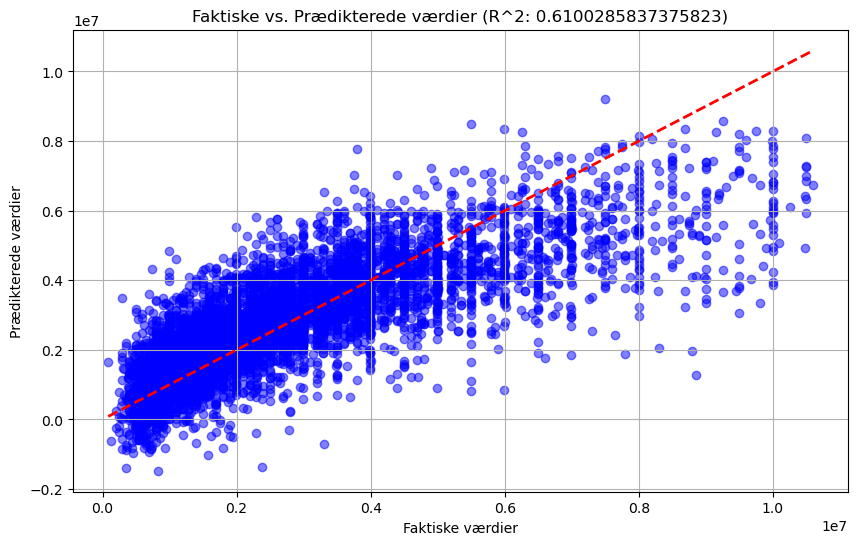

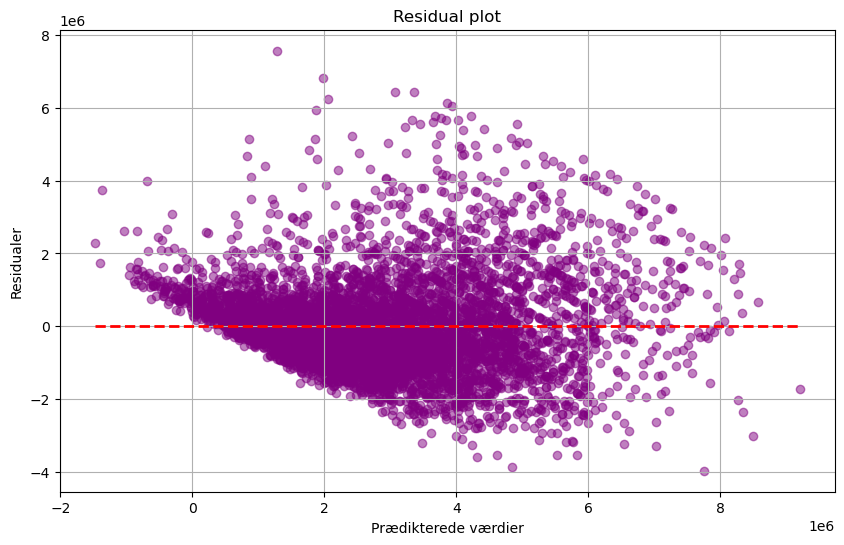

In [16]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_1 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de1', round(mse(y_test_pred_lasso_degree_1,y_test), 2))
print('Lasso_MAE_de1', round(mean_absolute_error(y_test_pred_lasso_degree_1, y_test), 2))
print('Lasso_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_1, y_test), 2))
print('Lasso_RMSE_de1', np.sqrt(mse(y_test_pred_lasso_degree_1, y_test)))
print('Lasso_R2_de1', r2_score(y_test, y_test_pred_lasso_degree_1))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_1.min(), y_test_pred_lasso_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# LASSO-MODEL MED DEGREE=2 and no Cross-validation

In [18]:
# Initialize Lasso-model with degree=2, CV=0
from sklearn.metrics import mean_squared_error as mse

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(0, 7, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=42))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 26024.633095283836
Validation MSE: 1216609073792.842


In [19]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=26024.633095283836))])

Lasso_MSE_de2 1231346172219.6
Lasso_MAE_de2 783013.5
Lasso_MAPE_de2 0.43
Lasso_RMSE_de2 1109660.3859828445
Lasso_R2_de2 0.6774518538148815


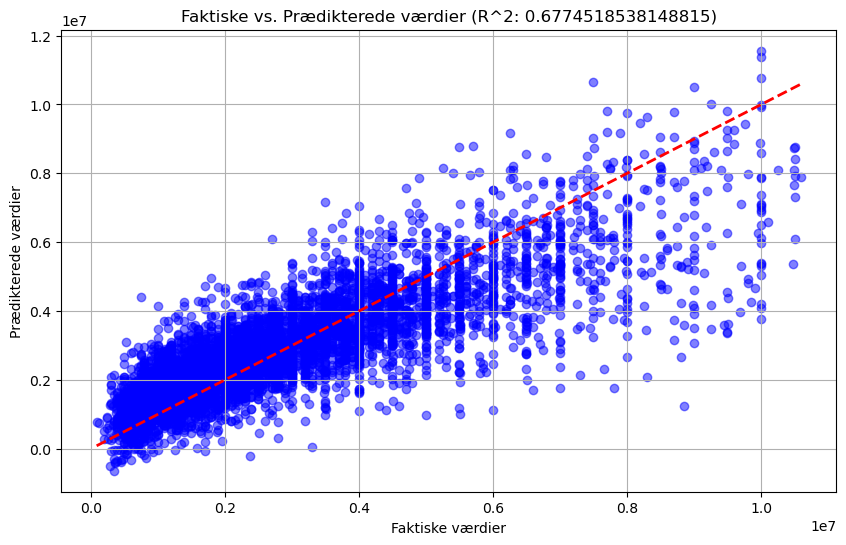

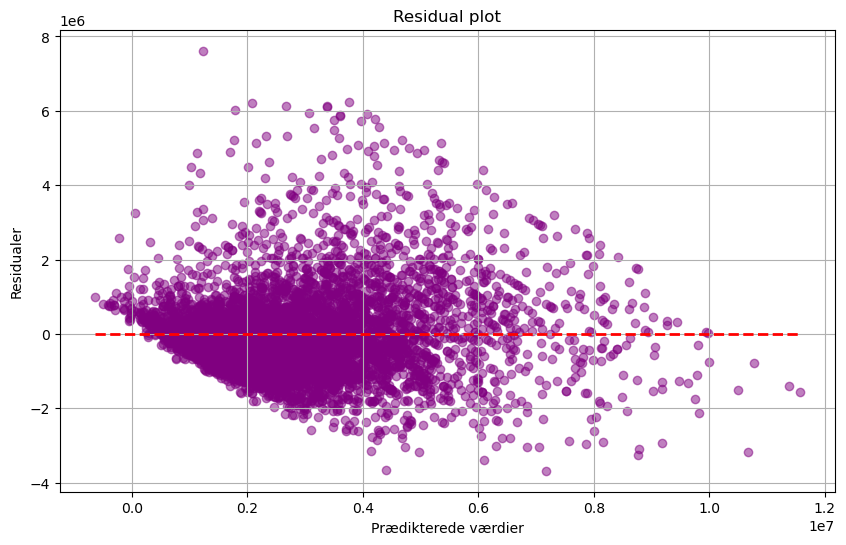

In [20]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_2 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de2', round(mse(y_test_pred_lasso_degree_2,y_test), 2))
print('Lasso_MAE_de2', round(mean_absolute_error(y_test_pred_lasso_degree_2, y_test), 2))
print('Lasso_MAPE_de2', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_2, y_test), 2))
print('Lasso_RMSE_de2', np.sqrt(mse(y_test_pred_lasso_degree_2, y_test)))
print('Lasso_R2_de2', r2_score(y_test, y_test_pred_lasso_degree_2))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_2, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_2)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_2

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_2, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_2.min(), y_test_pred_lasso_degree_2.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# Lasso, Poly-degree = 1, CV = 5

In [ ]:
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                                   StandardScaler(),
                                   Lasso(alpha=lambda_, random_state=42))
        pipe_lasso.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_lasso.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Lasso Regression')
plt.grid(True)
plt.show()

In [ ]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

In [ ]:
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_1_cv_5 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de1_cv_5', round(mse(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
print('Lasso_MAE_de1_cv_5', round(mean_absolute_error(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
print('Lasso_MAPE_de1_cv_5', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
print('Lasso_RMSE_de1_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_1_cv_5, y_test)))
print('Lasso_R2_de1_cv_5', r2_score(y_test, y_test_pred_lasso_degree_1_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_1_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_1_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_1_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_1_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_1_cv_5.min(), y_test_pred_lasso_degree_1_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# LASSO, poly-degree=2, CV=5

In [ ]:
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                                   StandardScaler(),
                                   Lasso(alpha=lambda_, random_state=42))
        pipe_lasso.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_lasso.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Lasso Regression')
plt.grid(True)
plt.show()

In [ ]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

In [ ]:
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_2_cv_5 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de2_cv_5', round(mse(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Lasso_MAE_de2_cv_5', round(mean_absolute_error(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Lasso_MAPE_de2_cv_5', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Lasso_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_2_cv_5, y_test)))
print('Lasso_R2_de2_cv_5', r2_score(y_test, y_test_pred_lasso_degree_2_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_2_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_2_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_2_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_2_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_2_cv_5.min(), y_test_pred_lasso_degree_2_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# RIDGE MODEL, degree = 1, CV=0

Optimal lambda: 21.54434690031882
Validation MSE: 1399014359602.473


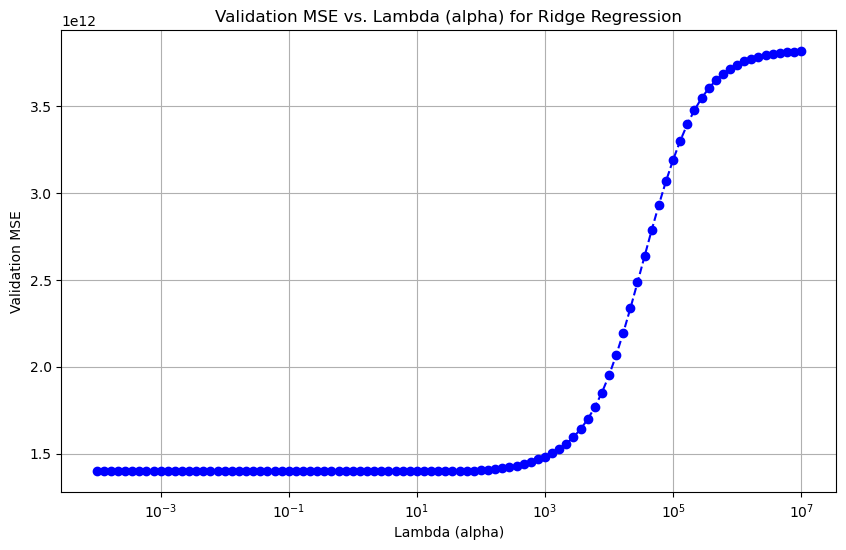

In [203]:
#Initialize the Ridge-model with degree = 1 and cv = 0
# Initialize Lasso-model with degree=2, CV=0

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(-4, 7, 100) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=42))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()



In [205]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=21.54434690031882))])

Ridge_MSE_de1 1411674545714.82
Ridge_MAE_de1 849293.37
Ridge_MAPE_de1 0.66
Ridge_RMSE_de1 1188139.1104221824
Ridge_R2_de1 0.6302152733245923


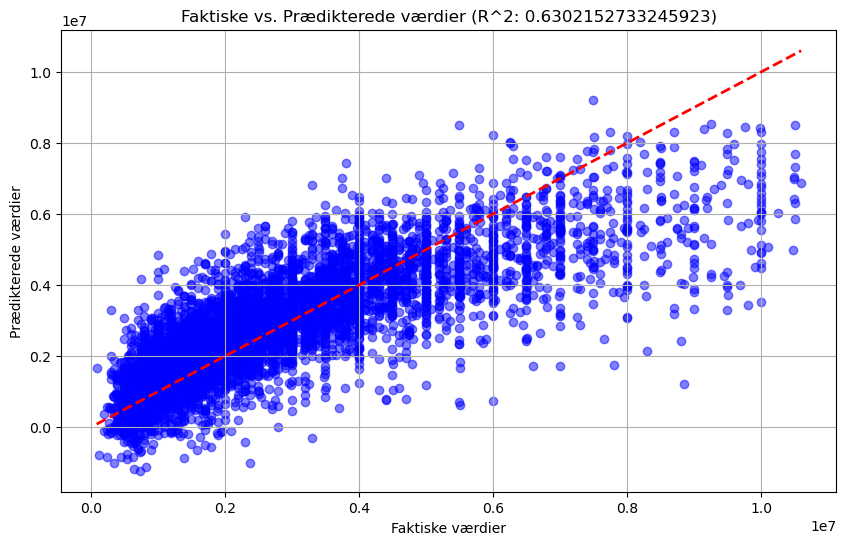

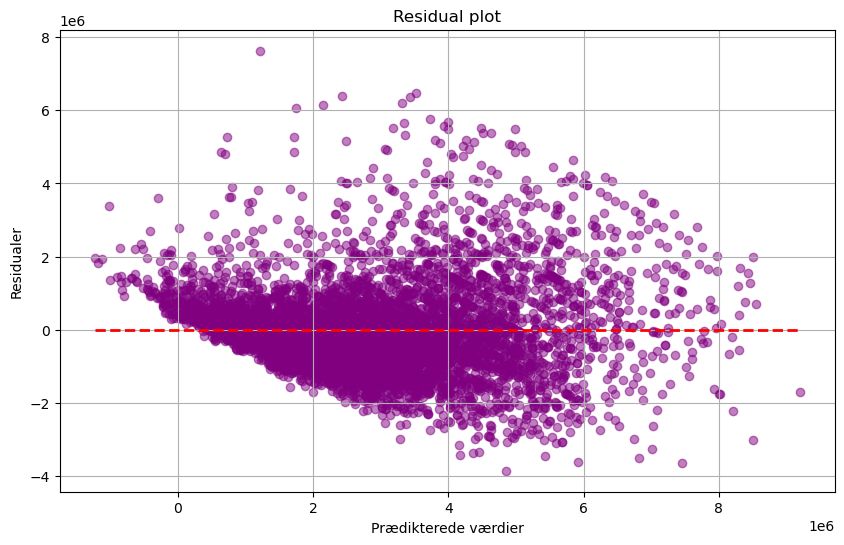

[4261795.31401633 2535552.98542205 2215138.87365203 ... 1986075.81175691
 1887151.72075796 2000376.90128228]


In [207]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_1 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de1', round(mse(y_test_pred_ridge_degree_1,y_test), 2))
print('Ridge_MAE_de1', round(mean_absolute_error(y_test_pred_ridge_degree_1, y_test), 2))
print('Ridge_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_1, y_test), 2))
print('Ridge_RMSE_de1', np.sqrt(mse(y_test_pred_ridge_degree_1, y_test)))
print('Ridge_R2_de1', r2_score(y_test, y_test_pred_ridge_degree_1))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_1.min(), y_test_pred_ridge_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()

print(y_test_pred_ridge_degree_1)

In [209]:
# Access the Ridge model coefficients after fitting
ridge_model = pipe_ridge.named_steps['ridge']
coefficients = ridge_model.coef_

# Get feature names from PolynomialFeatures
feature_names = pipe_ridge.named_steps['polynomialfeatures'].get_feature_names_out(X_train.columns)

# Combine feature names with coefficients
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coefficients_df['Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df.sort_values(by='Coefficient',ascending=False)

,Feature,Coefficient
24,anmeldelser pr 1000,1.455710e+06
25,sigtelser pr 1000,8.664459e+05
6,m2,6.535147e+05
15,Familiernes gennemsnitlige indkomst indkomst,5.429795e+05
19,andel_ikke_vestlig_opr,3.160776e+05
50,Energy-classification_ A2015,3.065344e+05
43,Boligtype_Ejerlejlighed,3.030384e+05
23,Karakter,2.932690e+05
21,Antal_laeger,2.840492e+05
7,Grund,2.424386e+05


# RIDGE, degree=2, CV=0

Optimal lambda: 14508.287784959402
Validation MSE: 1424890168644.694


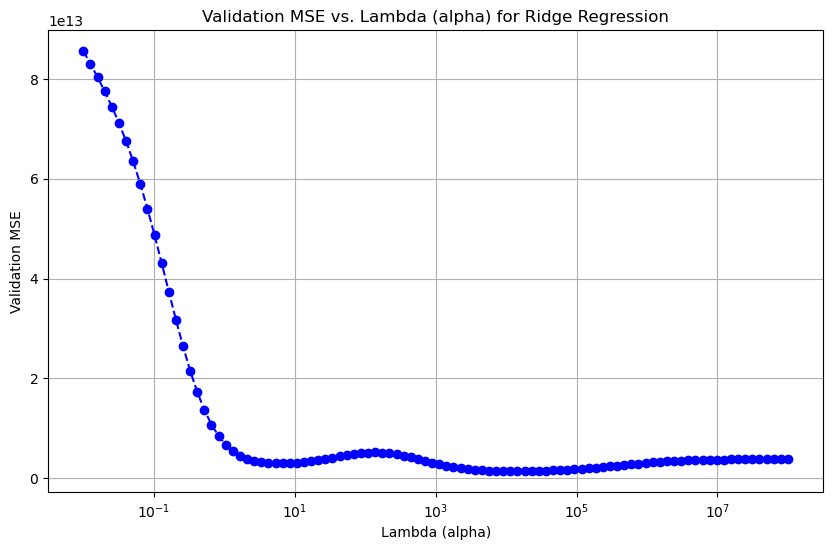

In [195]:
#Initialize the Ridge-model with degree = 1 and cv = 0
# Initialize Lasso-model with degree=2, CV=0

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(-2, 8, 100) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=42))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()





In [197]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=14508.287784959402))])

Ridge_MSE_de2 1239414480842.97
Ridge_MAE_de2 782702.34
Ridge_MAPE_de2 0.43
Ridge_RMSE_de2 1113289.9356605054
Ridge_R2_de2 0.675338379920998


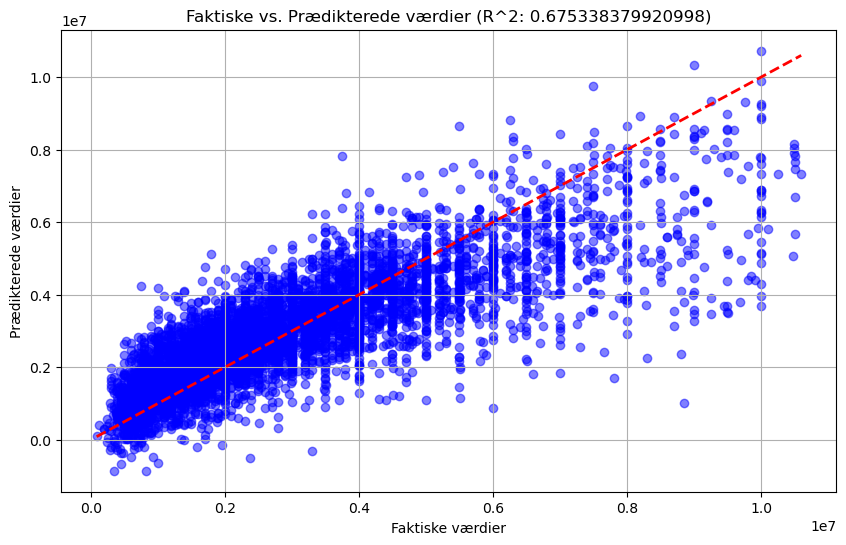

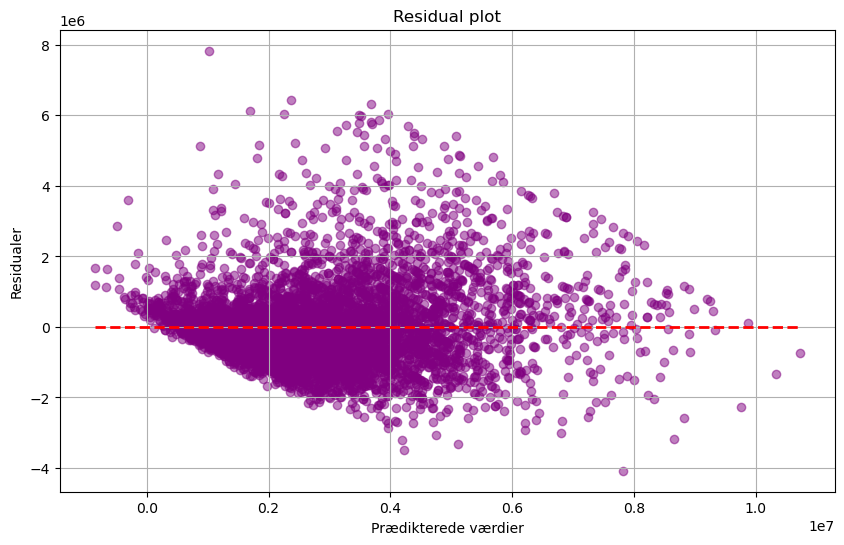

[4182794.38151188 2213672.09521523 1966638.57793019 ... 2271779.35398343
 1743303.44038071 2004744.95062143]


In [199]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_2 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de2', round(mse(y_test_pred_ridge_degree_2,y_test), 2))
print('Ridge_MAE_de2', round(mean_absolute_error(y_test_pred_ridge_degree_2, y_test), 2))
print('Ridge_MAPE_de2', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_2, y_test), 2))
print('Ridge_RMSE_de2', np.sqrt(mse(y_test_pred_ridge_degree_2, y_test)))
print('Ridge_R2_de2', r2_score(y_test, y_test_pred_ridge_degree_2))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_2, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_2)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_2

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_2, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_2.min(), y_test_pred_ridge_degree_2.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()

print(y_test_pred_ridge_degree_2)

In [201]:
# Access the Ridge model coefficients after fitting
ridge_model = pipe_ridge.named_steps['ridge']
coefficients = ridge_model.coef_

# Get feature names from PolynomialFeatures
feature_names = pipe_ridge.named_steps['polynomialfeatures'].get_feature_names_out(X_train.columns)

# Combine feature names with coefficients
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coefficients_df.sort_values(by='Coefficient', ascending=True)

,Feature,Coefficient
1115,Gennemsnitlig_pendligafstand sigtelser pr 1000,-60318.965823
1870,Whisky Boligtype_Ejerlejlighed,-53287.485155
921,"m2 parker, sportsanlæg og rekreative omr pr indbygger indbyggertal",-36385.196250
81,Distance to school indbyggertal,-33022.012191
929,"m2 parker, sportsanlæg og rekreative omr pr indbygger sigtelser pr 1000",-32202.848792
...,...,...
564,Rooms anmeldelser pr 1000,56898.393900
879,Familiernes gennemsnitlige indkomst indkomst anmeldelser pr 1000,57210.248157
388,m2 andel_ikke_vestlig_opr,71792.871971
384,m2 Familiernes gennemsnitlige indkomst indkomst,73246.514854


# Ridge, polynomial-features = 1, CV=5

In [ ]:
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                                   StandardScaler(),
                                   Ridge(alpha=lambda_, random_state=42))
        pipe_ridge.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_ridge.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()

In [ ]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

In [ ]:
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_1_cv_5 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de1_cv_5', round(mse(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_MAE_de1_cv_5', round(mean_absolute_error(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_MAPE_de1_cv_5', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_RMSE_de1_cv_5', np.sqrt(mse(y_test_pred_ridge_degree_1_cv_5, y_test)))
print('Ridge_R2_de1_cv_5', r2_score(y_test, y_test_pred_ridge_degree_1_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_1_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_1_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_1_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_1_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_1_cv_5.min(), y_test_pred_ridge_degree_1_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# Ridge, polynomial-features = 2, CV=5

Optimal lambda: 46415.88833612782
Validation MSE: 1642138923691.266


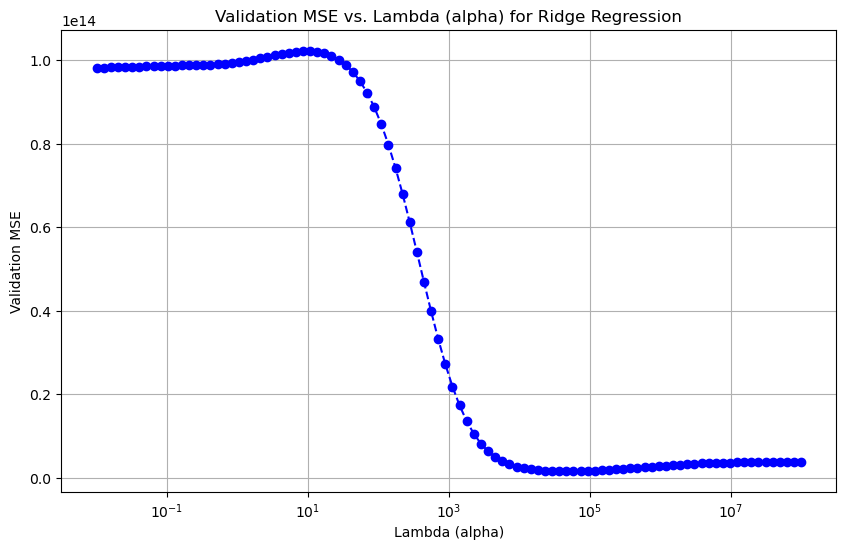

In [249]:
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                                   StandardScaler(),
                                   Ridge(alpha=lambda_, random_state=42))
        pipe_ridge.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_ridge.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()

In [252]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=46415.88833612782))])

Ridge_MSE_de2 1419686920959.5
Ridge_MAE_de2 852491.67
Ridge_MAPE_de2 0.58
Ridge_RMSE_de2 1191506.1564924868
Ridge_R2_de2 0.6281164510437272


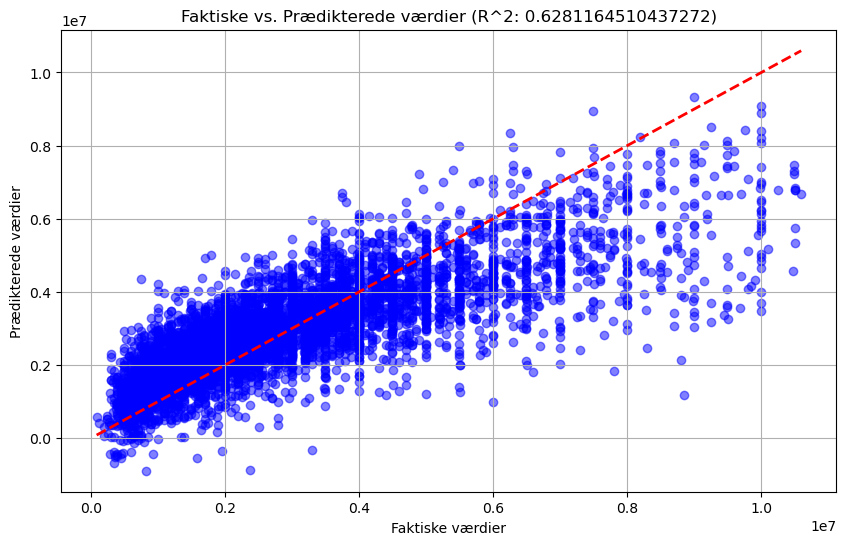

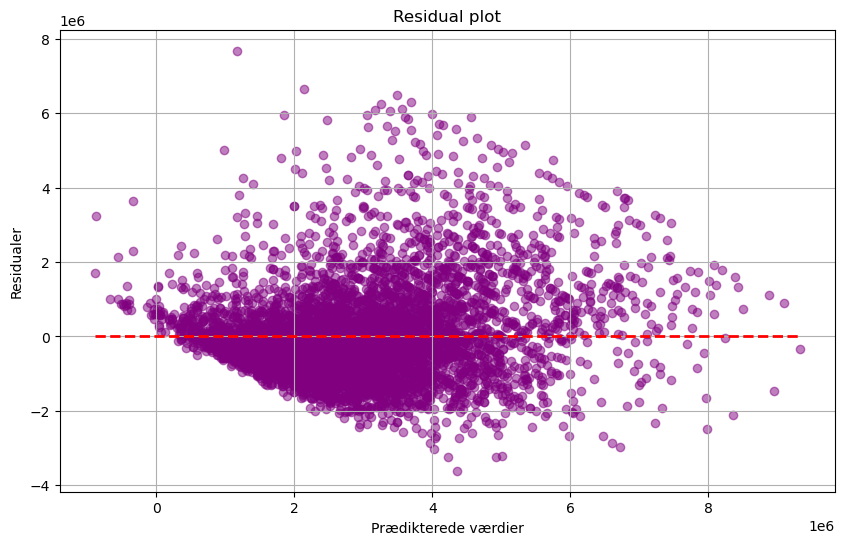

In [256]:
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_2_cv_5 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de2_cv_5', round(mse(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('Ridge_MAE_de2_cv_5', round(mean_absolute_error(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('Ridge_MAPE_de2_cv_5', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('Ridge_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_ridge_degree_2_cv_5, y_test)))
print('Ridge_R2_de2_cv_5', r2_score(y_test, y_test_pred_ridge_degree_2_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_2_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_2_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_2_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_2_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_2_cv_5.min(), y_test_pred_ridge_degree_2_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# RandomForestRegressor, degree=1, CV=0

In [214]:
from sklearn.ensemble import RandomForestRegressor

pipe_Randomforrest = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           RandomForestRegressor(random_state=42, n_estimators=100))


pipe_Randomforrest.fit(X_dev, y_dev)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [216]:
y_test_pred_randomforrest_degree_1 = pipe_Randomforrest.predict(X_test)
print('RandomForrest_MSE_de1', round(mse(y_test_pred_randomforrest_degree_1,y_test), 2))
print('RandomForrest_MAE_de1', round(mean_absolute_error(y_test_pred_randomforrest_degree_1, y_test), 2))
print('RandomForrest_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_randomforrest_degree_1, y_test), 2))
print('RandomForrest_RMSE_de1', np.sqrt(mse(y_test_pred_randomforrest_degree_1, y_test)))
print('RandomForrest_R2_de1', r2_score(y_test, y_test_pred_randomforrest_degree_1))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_randomforrest_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_randomforrest_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_randomforrest_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_randomforrest_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_randomforrest_degree_1.min(), y_test_pred_randomforrest_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()



Ridge_MSE_de2 639642559425.0
Ridge_MAE_de2 532274.65
Ridge_MAPE_de2 0.21
Ridge_RMSE_de2 799776.5684395854
Ridge_R2_de2 0.8324471814520378


In [226]:
diff = (y_test_pred_randomforrest_degree_1 - y_test)/y_test

In [246]:
# Determine the observations within the 15% threshold
within_15_percent = np.abs(diff) <= 0.35

# Count the observations
count_within_15_percent = np.sum(within_15_percent)

#
andel = count_within_15_percent/len(diff)
print(andel)

0.8016542070940035


# RandomForrest, poly-degree = 2

In [ ]:
from sklearn.ensemble import RandomForestRegressor

pipe_Randomforrest = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           RandomForestRegressor(random_state=42, n_estimators=100))


pipe_Randomforrest.fit(X_dev, y_dev)


In [ ]:
y_test_pred_randomforrest_degree_2 = pipe_Randomforrest.predict(X_test)
print('RandomForrest_MSE_de1', round(mse(y_test_pred_randomforrest_degree_2,y_test), 2))
print('RandomForrest_MAE_de1', round(mean_absolute_error(y_test_pred_randomforrest_degree_2, y_test), 2))
print('RandomForrest_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_randomforrest_degree_2, y_test), 2))
print('RandomForrest_RMSE_de1', np.sqrt(mse(y_test_pred_randomforrest_degree_2, y_test)))
print('RandomForrest_R2_de1', r2_score(y_test, y_test_pred_randomforrest_degree_2))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_randomforrest_degree_2, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_randomforrest_degree_2)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_randomforrest_degree_2

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_randomforrest_degree_2, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_randomforrest_degree_2.min(), y_test_pred_randomforrest_degree_2.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()



# Conclusion

In [ ]:
print('LinReg_MSE_de1', round(mse(y_predict_lr_degree_1,y_test), 2))
print('LinReg_MSE_de2', round(mse(y_predict_lr_degree_2,y_test), 2))
print('Lasso_MSE_de1', round(mse(y_test_pred_lasso_degree_1,y_test), 2))
print('Lasso_MSE_de2', round(mse(y_test_pred_lasso_degree_2,y_test), 2))
print('Lasso_MSE_de1_cv_5', round(mse(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
print('Lasso_MSE_de2_cv_5', round(mse(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Ridge_MSE_de1', round(mse(y_test_pred_ridge_degree_1,y_test), 2))
print('Ridge_MSE_de2', round(mse(y_test_pred_ridge_degree_2,y_test), 2))
print('Ridge_MSE_de1_cv_5', round(mse(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_MSE_de2_cv_5', round(mse(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('RandomForrest_MSE_de1', round(mse(y_test_pred_randomforrest_degree_1,y_test), 2))
print('RandomForrest_MSE_de1', round(mse(y_test_pred_randomforrest_degree_2,y_test), 2))




